In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("viethoang0805/serviceandelectronics")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/serviceandelectronics


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from peft import LoraConfig, get_peft_model, TaskType
import warnings
warnings.filterwarnings('ignore')

import gc
import peft
gc.collect()
torch.cuda.empty_cache()

# GPU checking
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-11-26 12:50:34.939550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764161435.150774      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764161435.215206      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [3]:
csv_file = '/kaggle/input/serviceandelectronics/merged_dataset_all_7700rows.csv'
print(f"Đang đọc file {csv_file}...")

df = pd.read_csv(csv_file)

print(f"\n✓ Đã đọc {len(df):,} dòng dữ liệu")
print(f"\nCác cột: {df.columns.tolist()}")
print(f"\nDữ liệu mẫu:")
df.head()

Đang đọc file /kaggle/input/serviceandelectronics/merged_dataset_all_7700rows.csv...

✓ Đã đọc 7,788 dòng dữ liệu

Các cột: ['reviewText', 'AspectTerm', 'Sentiment']

Dữ liệu mẫu:


,reviewText,AspectTerm,Sentiment
0,"While the tablet is nice, and well constructed...",google play,neutral
1,Highly recommended for those looking for that ...,food recommendation,positive
2,"ZICO Pure Premium Coconut Water , Natural , 11...",food general,positive
3,This is the only time I have strongly disliked...,food quality,negative
4,"Located on Via Della Scala , it was the perfec...",location general,positive


In [4]:
print(df['Sentiment'].value_counts())

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print(f"\nMapping labels:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {i}")

# Xử lý missing values
df = df.dropna(subset=['reviewText', 'AspectTerm', 'Sentiment'])

print(f"\nSố dòng sau khi xử lý: {len(df):,}")

Sentiment
positive    3000
negative    3000
neutral     1788
Name: count, dtype: int64

Mapping labels:
  negative: 0
  neutral: 1
  positive: 2

Số dòng sau khi xử lý: 7,788


In [5]:
# Train/val/test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

print(f"\nTrain distribution:")
print(train_df['Sentiment'].value_counts())
print(f"\nTest distribution:")
print(test_df['Sentiment'].value_counts())
print(f"\nVal distribution:")
print(val_df['Sentiment'].value_counts())

Train set: 5,451 samples
Validation set: 1,168 samples
Test set: 1,169 samples

Train distribution:
Sentiment
negative    2100
positive    2100
neutral     1251
Name: count, dtype: int64

Test distribution:
Sentiment
positive    450
negative    450
neutral     269
Name: count, dtype: int64

Val distribution:
Sentiment
negative    450
positive    450
neutral     268
Name: count, dtype: int64


In [6]:
# Custom Dataset class
class AspectSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        review = str(self.data.loc[idx, 'reviewText'])
        aspect = str(self.data.loc[idx, 'AspectTerm'])
        label = self.data.loc[idx, 'label']
        
        # Kết hợp review và aspect: "[CLS] review [SEP] aspect "
        combined_text = "[CLS] review: " + review + " [SEP] aspect: " + aspect + "[SEP]"
        
        # Tokenize
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
print("✓ Tokenizer loaded")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

✓ Tokenizer loaded


In [7]:
# Tạo DataLoader
BATCH_SIZE = 256
MAX_LEN = 128

train_dataset = AspectSentimentDataset(train_df, tokenizer, MAX_LEN)
val_dataset = AspectSentimentDataset(val_df, tokenizer, MAX_LEN)
test_dataset = AspectSentimentDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ DataLoaders created
  Train batches: 22
  Val batches: 5
  Test batches: 5


In [8]:
# Model: DistilBERT + LSTM
class DistilBertLSTMClassifier(nn.Module):
    def __init__(self, n_classes=3, lstm_hidden_size=128, lstm_layers=2, dropout=0.3):
        super(DistilBertLSTMClassifier, self).__init__()
        # DistilBERT
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels = n_classes)
        for param in self.distilbert.parameters():
            param.requires_grad = False
        
        for name, param in self.distilbert.named_parameters():
            if "bias" in name:
                param.requires_grad = True
            if "layernorm" in name.lower():
                param.requires_grad = True

        for name, param in self.distilbert.named_parameters():
            if name.startswith("transformer.layer.5."):
                param.requires_grad = True
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=768,  # DistilBERT hidden size
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Classifier
        self.fc = nn.Linear(lstm_hidden_size * 2, n_classes)  # *2 for bidirectional
        
    def forward(self, input_ids, attention_mask):
        # DistilBERT embeddings
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # last_hidden_state: [batch_size, seq_len, 768]
        sequence_output = distilbert_output.last_hidden_state
        
        # LSTM
        lstm_output, (hidden, cell) = self.lstm(sequence_output)
        
        # Lấy output từ hidden state cuối cùng của cả 2 directions
        # hidden: [num_layers * 2, batch_size, hidden_size]
        # Lấy layer cuối: [-2:] -> [2, batch_size, hidden_size]
        hidden_fwd = hidden[-2, :, :]  # forward direction
        hidden_bwd = hidden[-1, :, :]  # backward direction
        
        # Concatenate
        hidden_concat = torch.cat((hidden_fwd, hidden_bwd), dim=1)
        
        # Dropout
        hidden_concat = self.dropout(hidden_concat)
        
        # Classifier
        output = self.fc(hidden_concat)
        
        return output

# Khởi tạo model
model = DistilBertLSTMClassifier(n_classes=3)

# lora_config = LoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=16,
#     lora_alpha=24,
#     lora_dropout=0.1,
#     target_modules=["q_lin", "v_lin", "k_lin", "out_lin"],
#     # bias="all",
# )
# distilbert = get_peft_model(model, lora_config)
model = model.to(device)

print("✓ Model created")
print(f"\nModel architecture:")
print(model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✓ Model created

Model architecture:
DistilBertLSTMClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Drop

In [9]:
# Training configuration
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

EPOCHS = 15
LEARNING_RATE = 2e-5

# Loss function và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# total_steps = len(train_loader) * EPOCHS
# warmup_steps = int(0.05 * total_steps)  # 5% first step warmup
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=warmup_steps,
#     num_training_steps=total_steps
# )

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Device: {device}")

Training configuration:
  Epochs: 15
  Learning rate: 2e-05
  Batch size: 256
  Device: cuda


In [10]:
# Training functions
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

print("Training functions defined")

Training functions defined


In [11]:
# Training loop
import time

print("=" * 80)
print("TRAINING START")
print("=" * 80)

best_val_acc = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"  ✓ Best model saved!")
    
    elapsed = time.time() - start_time
    
    print(f"\nEpoch {epoch+1}/{EPOCHS} - {elapsed:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print("-" * 80)

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("=" * 80)

TRAINING START
  ✓ Best model saved!

Epoch 1/15 - 50.25s
  Train Loss: 1.0743 | Train Acc: 0.4051
  Val Loss: 1.0529 | Val Acc: 0.5171
--------------------------------------------------------------------------------
  ✓ Best model saved!

Epoch 2/15 - 52.95s
  Train Loss: 1.0294 | Train Acc: 0.4876
  Val Loss: 0.9955 | Val Acc: 0.6233
--------------------------------------------------------------------------------
  ✓ Best model saved!

Epoch 3/15 - 56.22s
  Train Loss: 0.9452 | Train Acc: 0.6632
  Val Loss: 0.8885 | Val Acc: 0.7140
--------------------------------------------------------------------------------
  ✓ Best model saved!

Epoch 4/15 - 58.78s
  Train Loss: 0.8318 | Train Acc: 0.7149
  Val Loss: 0.7776 | Val Acc: 0.7526
--------------------------------------------------------------------------------
  ✓ Best model saved!

Epoch 5/15 - 60.34s
  Train Loss: 0.7152 | Train Acc: 0.7705
  Val Loss: 0.6558 | Val Acc: 0.7868
--------------------------------------------------------

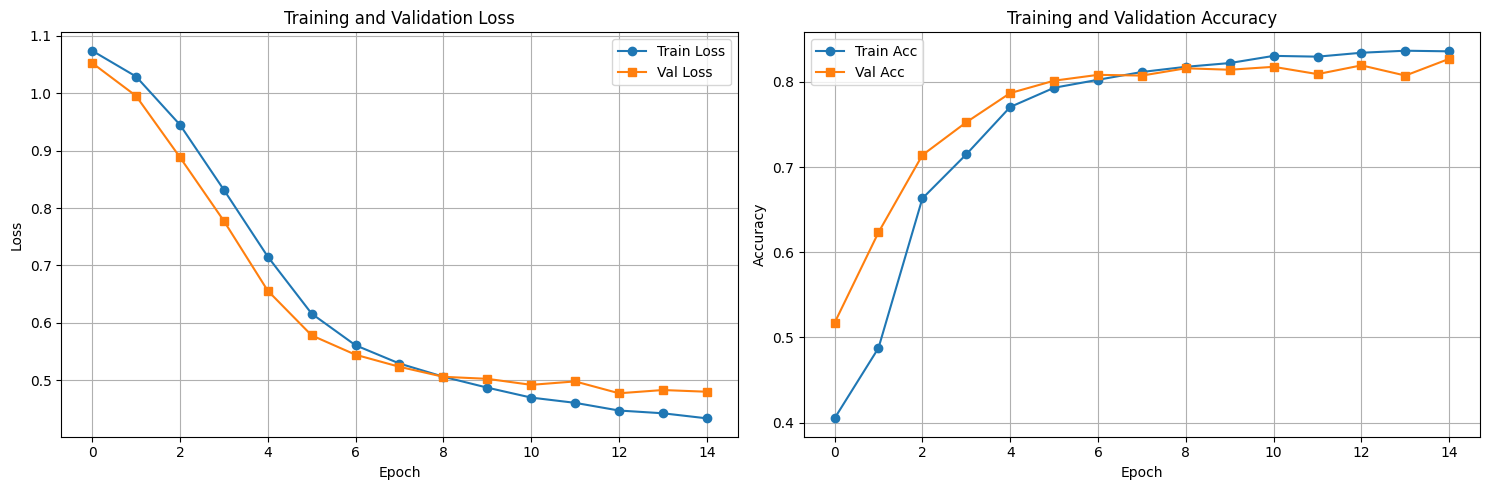

In [12]:
# Visualize training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Evaluate on test set
print("=" * 80)
print("EVALUATING ON TEST SET")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc, test_preds, test_labels = eval_model(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=label_encoder.classes_,
    digits=4
))

EVALUATING ON TEST SET

Test Loss: 0.4695
Test Accuracy: 0.8229

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative     0.7945    0.8422    0.8177       450
     neutral     0.9324    0.7175    0.8109       269
    positive     0.8041    0.8667    0.8342       450

    accuracy                         0.8229      1169
   macro avg     0.8437    0.8088    0.8209      1169
weighted avg     0.8299    0.8229    0.8225      1169



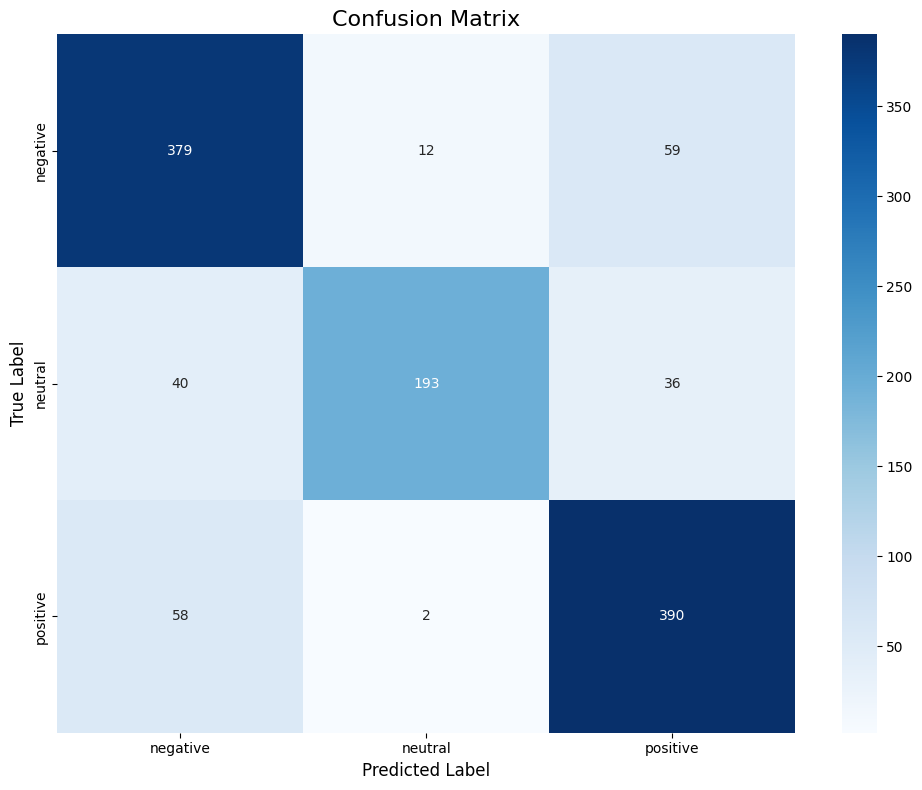

In [14]:
# Confusion Matrix
import seaborn as sns

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
# Save model state
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'max_len': MAX_LEN,
    'history': history
}, 'distilbert_lstm_model_complete.pt')

# Model summary
print("\n" + "=" * 80)
print("MODEL SUMMARY")
print("=" * 80)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


MODEL SUMMARY
Total parameters: 67,678,467
Trainable parameters: 8,447,235

Best Validation Accuracy: 0.8271
Test Accuracy: 0.8229
